# SQL Import

In [1]:
import pymysql
import pandas as pd

from dotenv import load_dotenv
from os import getenv

In [37]:
load_dotenv(dotenv_path = '.env')

True

In [38]:
getenv('host')

'learning-1000ml.c0zbrffehjje.us-east-2.rds.amazonaws.com'

In [39]:
conn = pymysql.connect(host = getenv('host'),
                       port = int(getenv('port')),
                       user = getenv('user'),
                       passwd = getenv('password'),
                       db = 'financial')

In [40]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:

    table = pd.read_sql("select * from `%s`" % name, conn)
    table.to_csv('tables/%s.csv' % name, index = False)
    print(table.tail(2))
    print('')

      account_id  district_id         frequency        date
4498       11362           67  POPLATEK MESICNE  1995-10-14
4499       11382           74  POPLATEK MESICNE  1995-08-20

     card_id  disp_id     type      issued
890     1239    13442   junior  1998-02-02
891     1247    13660  classic  1995-06-13

      client_id gender  birth_date  district_id
5367      13971      F  1962-10-19           67
5368      13998      F  1953-08-12           74

      disp_id  client_id  account_id   type
5367    13663      13971       11362  OWNER
5368    13690      13998       11382  OWNER

    district_id       A2             A3      A4  A5  A6  A7  A8  A9   A10  \
75           76  Sumperk  north Moravia  127369  31  32  13   2   7  51.2   
76           77   Vsetin  north Moravia  148545   8  35  12   3   4  53.5   

     A11  A12   A13  A14     A15   A16  
75  8369  4.7  5.88  107  3736.0  2807  
76  8909  4.0  5.56  113  3460.0  3590  

     loan_id  account_id        date  amount  duration 

In [41]:
#Close connection
conn.close()

# Load in the Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [109]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:
    exec("%s = pd.read_csv('tables/%s.csv')" % (name,name))

/home/steve/Desktop/Unit4_Project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [110]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:
    

#     table = pd.read_sql("select * from `%s`" % name, conn)
#     table.to_csv('tables/%s.csv' % name, index = False)
    exec("print(%s.tail(2))" % name)
    print('')

      account_id  district_id         frequency        date
4498       11362           67  POPLATEK MESICNE  1995-10-14
4499       11382           74  POPLATEK MESICNE  1995-08-20

     card_id  disp_id     type      issued
890     1239    13442   junior  1998-02-02
891     1247    13660  classic  1995-06-13

      client_id gender  birth_date  district_id
5367      13971      F  1962-10-19           67
5368      13998      F  1953-08-12           74

      disp_id  client_id  account_id   type
5367    13663      13971       11362  OWNER
5368    13690      13998       11382  OWNER

    district_id       A2             A3      A4  A5  A6  A7  A8  A9   A10  \
75           76  Sumperk  north Moravia  127369  31  32  13   2   7  51.2   
76           77   Vsetin  north Moravia  148545   8  35  12   3   4  53.5   

     A11  A12   A13  A14     A15   A16  
75  8369  4.7  5.88  107  3736.0  2807  
76  8909  4.0  5.56  113  3460.0  3590  

     loan_id  account_id        date  amount  duration 

# EDA

* 682 loan_id
* 4500 account_id
* 892 card_id
* 5369 client_id
* 5369 disp_id
* 77 district_id
* 6471 order_id

<img src='https://relational.fit.cvut.cz/assets/img/datasets-generated/financial.svg' width='400'>

## SQL Merges

In [111]:
loan['status2'] = loan.status

loan.loc[loan['status2']=='C','status2'] = 'A'
loan.loc[loan['status2']=='B','status2'] = 'D'

In [112]:
#Join card and disp
disp_card = disp.drop(columns=['type']).merge(card,on='disp_id').drop(columns=['card_id','disp_id'])

#Join client and disp
disp_cc = disp_card.merge(client,on='client_id').drop(columns=['client_id','district_id'])

#Join disp and account
account_disp = account.merge(disp_cc,on='account_id')

In [113]:
account_disp.head(2)

,account_id,district_id,frequency,date,type,issued,gender,birth_date
0,7,60,POPLATEK MESICNE,1996-11-24,gold,1998-10-16,M,1935-10-16
1,14,47,POPLATEK MESICNE,1996-11-27,classic,1998-03-13,M,1942-12-28


In [114]:
#inner join order onto loan
loan_o = loan.merge(order,on='account_id',suffixes=('_loan','_order')).drop(columns=['order_id','account_to','k_symbol'])

#inner join trans onto loan
loan_ot = loan_o.merge(trans.drop(columns=['date','trans_id','bank','account','k_symbol','operation']),on='account_id',suffixes=('_order','_trans'))

In [115]:
loan_ot.head()

,loan_id,account_id,date,amount_loan,duration,payments,status,status2,bank_to,amount_order,type,amount,balance
0,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,1100,1100
1,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,20236,21336
2,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,20236,45286
3,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,20236,54631
4,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,30354,67530


In [116]:
#Join final loan with final account
loan_account = loan_ot.merge(account_disp,on='account_id',suffixes=('_loan','_account'))

In [117]:
loan_account.head(2)

,loan_id,account_id,date_loan,amount_loan,duration,payments,status,status2,bank_to,amount_order,type_loan,amount,balance,district_id,frequency,date_account,type_account,issued,gender,birth_date
0,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,900,900,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28
1,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,17928,18828,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28


In [153]:
#Join final loan/account with district
loan_final = loan_account.merge(district,on='district_id').drop(columns=['A2','A12','A15'])

In [154]:
loan_final.head(2)

,loan_id,account_id,date_loan,amount_loan,duration,payments,status,status2,bank_to,amount_order,type_loan,amount,balance,district_id,frequency,date_account,type_account,issued,gender,birth_date,A3,A4,A5,A6,A7,A8,A9,A10,A11,A13,A14,A16
0,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,900,900,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
1,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,17928,18828,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347


In [155]:
data = loan_final.drop(columns=['status','loan_id','account_id','date_loan','date_account','issued','birth_date'])

In [156]:
data.columns

Index(['amount_loan', 'duration', 'payments', 'status2', 'bank_to',
       'amount_order', 'type_loan', 'amount', 'balance', 'district_id',
       'frequency', 'type_account', 'gender', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16'],
      dtype='object')

In [157]:
loan_final.nunique()

loan_id           170
account_id        170
date_loan         163
amount_loan       168
duration            5
payments          161
status              4
status2             2
bank_to            13
amount_order      339
type_loan           3
amount           7054
balance         36286
district_id        60
frequency           3
date_account      162
type_account        3
issued            160
gender              2
birth_date        168
A3                  8
A4                 60
A5                 44
A6                 30
A7                 16
A8                  6
A9                 11
A10                54
A11                59
A13                56
A14                36
A16                60
dtype: int64

In [158]:
binary_variables = ['gender']

continuous_variables = ['amount_loan', 'duration', 'payments', 
                        'amount_order','amount', 'balance',
                        'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                        'A10', 'A11', 'A13', 'A14', 
                        'A16']

target_variables = ['status2']

nominal_cat_variables = [x for x in data.columns.to_list() if x not in set(binary_variables + continuous_variables + target_variables)]

In [159]:
len(continuous_variables)

17

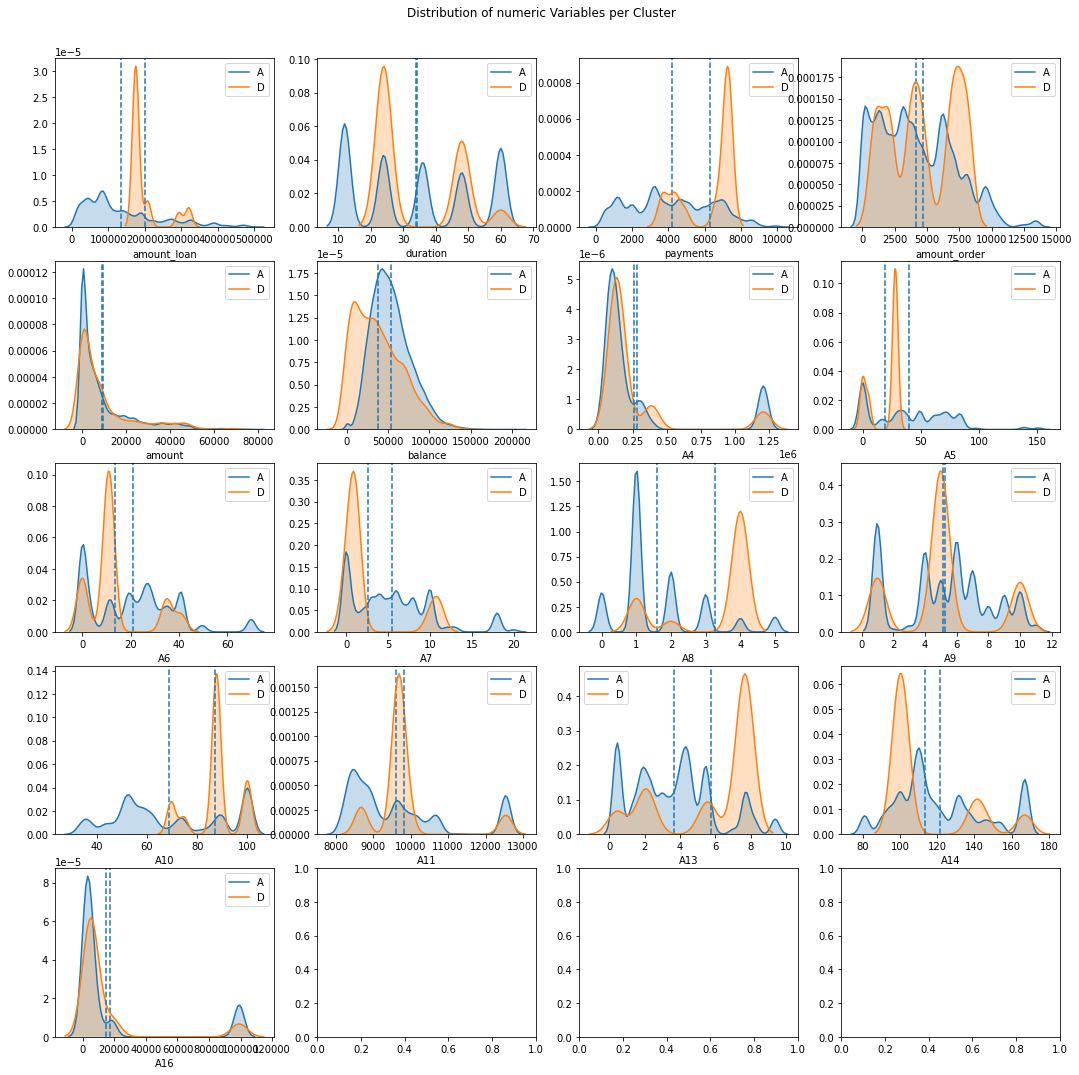

In [160]:
fig, axs = plt.subplots(5,4, figsize=(18,18))

for column, ax in zip(continuous_variables, axs.flatten()):
     for each in ['A','D']:
        sns.kdeplot(data[column][data['status2']==each],ax=ax,label=each,shade=True)
        ax.axvline(data[column][data['status2']==each].mean(),ls='--')
        ax.set_xlabel(column)

plt.suptitle('Distribution of numeric Variables per Cluster', y=0.92)
plt.show()

In [161]:
#Set x and y variables
x = data.drop(columns = 'status2')
y = data.status2

#Train test split
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size = 0.2,
                                                    random_state = 42)

data_transformer = ColumnTransformer(transformers=[
    ('continuous', 'passthrough', continuous_variables),
    ('binary', OrdinalEncoder(), binary_variables),
    ('nominal', OneHotEncoder(sparse=False), nominal_cat_variables)],
                                    remainder = 'drop')

# Feature Selection 

In [162]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

In [163]:
variance_picking = Pipeline([('scaler', MinMaxScaler()),
                            ('var_thres', VarianceThreshold(threshold=0.06))])

variance_picking.fit(x_train[continuous_variables])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('var_thres', VarianceThreshold(threshold=0.06))])

In [164]:
variance_picking.named_steps['var_thres'].variances_.round(3)

array([0.046, 0.139, 0.054, 0.045, 0.026, 0.012, 0.1  , 0.047, 0.06 ,
       0.056, 0.064, 0.083, 0.107, 0.094, 0.071, 0.08 , 0.107])

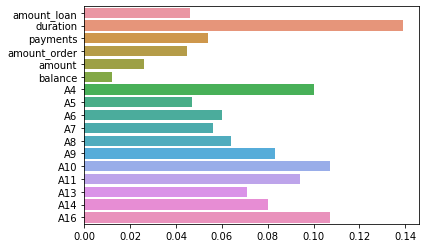

In [165]:
sns.barplot(variance_picking.named_steps['var_thres'].variances_.round(3),continuous_variables)

In [166]:
#a mask array letting you know which variables in the continuous variables are kept
variance_picking.named_steps['var_thres'].get_support()

array([False,  True, False, False, False, False,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True])

In [167]:
variance_picking.transform(x_train[continuous_variables]).shape

(83923, 9)

In [168]:
len(continuous_variables)

17

In [169]:
new_continuous_variables = [continuous_variables[value] 
                            for value in variance_picking.named_steps['var_thres'].get_support(indices=True)]

# Univariate Selection

In [170]:
from sklearn.feature_selection import chi2, SelectKBest

In [171]:
combined_cat_variables = binary_variables + nominal_cat_variables
combined_cat_variables

['gender',
 'bank_to',
 'type_loan',
 'district_id',
 'frequency',
 'type_account',
 'A3']

In [172]:
data[combined_cat_variables].isnull().sum()

gender          0
bank_to         0
type_loan       0
district_id     0
frequency       0
type_account    0
A3              0
dtype: int64

In [173]:
chi2_pipe_k = Pipeline([('ordinal_transform', OrdinalEncoder()),
                        ('SelectK', SelectKBest(score_func = chi2,
                                                k = 2))])

chi2_pipe_k.fit(x_train[combined_cat_variables],y_train)

Pipeline(steps=[('ordinal_transform', OrdinalEncoder()),
                ('SelectK',
                 SelectKBest(k=2,
                             score_func=<function chi2 at 0x7fe65c0ea0e0>))])

In [174]:
final_categorical_variables = [combined_cat_variables[value] 
                               for value in chi2_pipe_k.named_steps['SelectK'].get_support(indices=True)]

In [175]:
from sklearn.feature_selection import SelectFwe

In [176]:
chi2_pipe_fwe = Pipeline([('ordinal_transform', OrdinalEncoder()),
                         ('Selectfwe', SelectFwe(score_func = chi2, 
                                                 alpha = 0.05))])

In [177]:
chi2_pipe_fwe.fit(x_train[final_categorical_variables], y_train)

Pipeline(steps=[('ordinal_transform', OrdinalEncoder()),
                ('Selectfwe',
                 SelectFwe(score_func=<function chi2 at 0x7fe65c0ea0e0>))])

In [178]:
chi2_pipe_fwe.named_steps['Selectfwe'].get_support(indices=True)

array([0, 1])

# ANOVA

In [179]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

In [186]:
anova_pipe = Pipeline([('scaler', StandardScaler()),
                        ('anova', SelectKBest(score_func = f_classif,
                                              k = 'all'))])

In [187]:
new_continuous_variables

['duration', 'A4', 'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16']

In [188]:
data[new_continuous_variables].isnull().sum()

duration    0
A4          0
A8          0
A9          0
A10         0
A11         0
A13         0
A14         0
A16         0
dtype: int64

In [189]:
anova_pipe.fit(x_train[new_continuous_variables], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('anova', SelectKBest(k='all'))])

In [190]:
anova_pipe_fwe = Pipeline([('scaler', StandardScaler()),
                           ('select', SelectFwe(score_func = f_classif,
                                                alpha = 0.05))])

anova_pipe_fwe.fit(x_train[new_continuous_variables], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('select', SelectFwe())])

In [191]:
final_continuous_variables = [new_continuous_variables[value] 
                              for value in anova_pipe_fwe.named_steps['select'].get_support(indices=True)]
final_continuous_variables

['A4', 'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16']

# Random Forest

In [192]:
from sklearn.compose import ColumnTransformer

In [193]:
data_transformer = ColumnTransformer(transformers = [
                                    ('continuous','passthrough', final_continuous_variables),
                                    ('binary', OrdinalEncoder(), final_categorical_variables)],
                                    remainder = 'drop')

In [194]:
from sklearn.ensemble import RandomForestClassifier

In [197]:
rf_pipe = Pipeline([('transform', data_transformer),
                    ('rf', RandomForestClassifier(n_estimators = 100,
                                                  bootstrap = True,
                                                  max_samples = 0.9,
                                                  n_jobs = -1,
                                                  random_state = 42))])

In [198]:
from sklearn.model_selection import GridSearchCV

In [199]:
params = [{'rf__max_depth': [10, 15, None],
           'rf__max_leaf_nodes': [100, 150, None],
           'rf__max_features': ['auto', 'log2'],
           'rf__max_samples': [0.7, 0.8, 0.9]}]

In [200]:
rf_gridsearch = GridSearchCV(rf_pipe, params, n_jobs = -1, cv = 3)

rf_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         'passthrough',
                                                                         ['A4',
                                                                          'A8',
                                                                          'A9',
                                                                          'A10',
                                                                          'A11',
                                                                          'A13',
                                                                          'A14',
                                                                          'A16']),
                                                                        ('binary',
                       

In [202]:
rf_gridsearch.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': 100,
 'rf__max_samples': 0.7}

In [203]:
rf_gridsearch.best_score_

0.9871310684133121

In [204]:
final_rf = rf_gridsearch.best_estimator_

# Use SHAP on results

In [205]:
final_rf.score(x_train,y_train)

0.9871310606150876

In [1]:
final_rf.score(x_test,y_test)

NameError: name 'final_rf' is not defined

In [207]:
final_columns = final_continuous_variables + final_categorical_variables

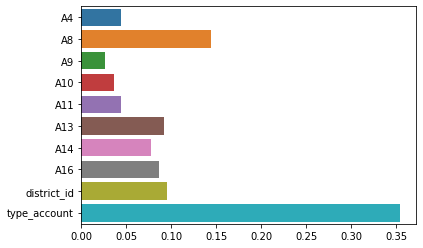

In [208]:
sns.barplot(final_rf[-1].feature_importances_.round(3),
            final_columns)

plt.show()

In [209]:
import shap

In [210]:
#Transform x_test with data transformer
x_test_transform = final_rf[:-1].transform(x_test)

#create the explainer using the decision tree
explainer = shap.TreeExplainer(final_rf[-1])

#calculate the shap values for the test data
shap_values = explainer.shap_values(x_test_transform)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [211]:
shap.initjs()

#plot the shapley value for an individual point
shap.force_plot(explainer.expected_value[1],
               shap_values[1][3],
               features = x_test_transform[3],
               feature_names = final_columns)

In [ ]:
shap.initjs()

#plot the shapley value for an individual point
shap.force_plot(explainer.expected_value[1],
               shap_values[1],
               features = x_test_transform,
               feature_names = final_columns)

shap.force_plot is slow for many thousands of rows, try subsampling your data.


In [ ]:
#Summary plot for churn values
shap.summary_plot(shap_values[1],
                 x_test_transform,
                 feature_names = final_columns)

### Loan

In [31]:
#amount = duration * payments
loan.head()

,loan_id,account_id,date,amount,duration,payments,status,status2
0,4959,2,1994-01-05,80952,24,3373.0,A,A
1,4961,19,1996-04-29,30276,12,2523.0,B,D
2,4962,25,1997-12-08,30276,12,2523.0,A,A
3,4967,37,1998-10-14,318480,60,5308.0,D,D
4,4968,38,1998-04-19,110736,48,2307.0,C,A


In [32]:
loan.nunique()

loan_id       682
account_id    682
date          559
amount        645
duration        5
payments      577
status          4
status2         2
dtype: int64

In [33]:
# 'A' stands for contract finished, no problems,
# 'B' stands for contract finished, loan not payed,
# 'C' stands for running contract, OK so far,
# 'D' stands for running contract, client in debt
loan.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [34]:
loan.head()

,loan_id,account_id,date,amount,duration,payments,status,status2
0,4959,2,1994-01-05,80952,24,3373.0,A,A
1,4961,19,1996-04-29,30276,12,2523.0,B,D
2,4962,25,1997-12-08,30276,12,2523.0,A,A
3,4967,37,1998-10-14,318480,60,5308.0,D,D
4,4968,38,1998-04-19,110736,48,2307.0,C,A


### Account

In [35]:
account.head(2)

,account_id,district_id,frequency,date
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26


In [36]:
account.nunique()

account_id     4500
district_id      77
frequency         3
date           1535
dtype: int64

### Card

In [37]:
card.head(2)

,card_id,disp_id,type,issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13


In [38]:
card.nunique()

card_id    892
disp_id    892
type         3
issued     607
dtype: int64

In [39]:
card.type.unique()

array(['gold', 'classic', 'junior'], dtype=object)

### Client

In [40]:
client.head(2)

,client_id,gender,birth_date,district_id
0,1,F,1970-12-13,18
1,2,M,1945-02-04,1


In [41]:
client.nunique()

client_id      5369
gender            2
birth_date     4738
district_id      77
dtype: int64

### Disp 

In [42]:
disp.tail(2)

,disp_id,client_id,account_id,type
5367,13663,13971,11362,OWNER
5368,13690,13998,11382,OWNER


In [43]:
disp.nunique()

disp_id       5369
client_id     5369
account_id    4500
type             2
dtype: int64

In [44]:
disp.type.unique()

array(['OWNER', 'DISPONENT'], dtype=object)

### District 

In [45]:
district.head(2)

,district_id,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674


In [46]:
district.nunique()

district_id    77
A2             77
A3              8
A4             77
A5             53
A6             36
A7             17
A8              6
A9             11
A10            70
A11            76
A12            41
A13            73
A14            44
A15            75
A16            76
dtype: int64

### Order

In [47]:
order.head(2)

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER


In [48]:
order.nunique()

order_id      6471
account_id    3758
bank_to         13
account_to    6446
amount        4412
k_symbol         4
dtype: int64

In [49]:
order.bank_to.unique()

array(['YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF',
       'MN', 'OP'], dtype=object)

In [50]:
order.k_symbol.unique()

array(['SIPO', 'UVER', nan, 'POJISTNE', 'LEASING'], dtype=object)

### Trans

In [51]:
trans.head(2)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
1,5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0


In [52]:
trans.nunique()

trans_id      1056320
account_id       4500
date             2191
type                3
operation           5
amount          35890
balance        111042
k_symbol            8
bank               13
account          7665
dtype: int64

In [53]:
trans.type.unique()

array(['PRIJEM', 'VYDAJ', 'VYBER'], dtype=object)

In [54]:
trans.operation.unique()

array(['VKLAD', 'PREVOD Z UCTU', 'PREVOD NA UCET', 'VYBER',
       'VYBER KARTOU', nan], dtype=object)

In [55]:
trans.k_symbol.unique()

array([nan, 'SIPO', 'SLUZBY', 'UVER', ' ', 'POJISTNE', 'DUCHOD', 'UROK',
       'SANKC. UROK'], dtype=object)

In [56]:
trans.bank.unique()

array([nan, 'AB', 'YZ', 'ST', 'QR', 'WX', 'CD', 'UV', 'KL', 'GH', 'OP',
       'IJ', 'EF', 'MN'], dtype=object)

## Plots

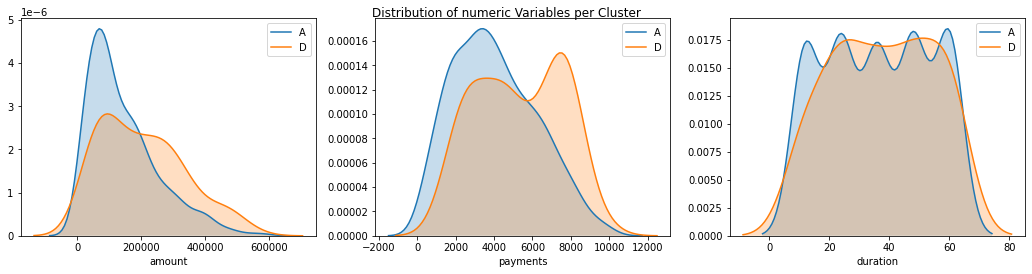

In [57]:
columns = ['amount','payments','duration']

fig, axs = plt.subplots(1,3, figsize=(18,4))

for column, ax in zip(columns, axs.flatten()):
     for each in ['A','D']:
        sns.kdeplot(loan[column][loan['status2']==each],ax=ax,label=each,shade=True)
        ax.set_xlabel(column)

plt.suptitle('Distribution of numeric Variables per Cluster', y=0.92)
plt.show()



In [58]:
loan.head(2)

,loan_id,account_id,date,amount,duration,payments,status,status2
0,4959,2,1994-01-05,80952,24,3373.0,A,A
1,4961,19,1996-04-29,30276,12,2523.0,B,D


In [59]:
account.head(2)

,account_id,district_id,frequency,date
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26


In [60]:
loan_account = loan.merge(account,on='account_id',suffixes=('_loan','_account'))
loan_account

,loan_id,account_id,date_loan,amount,duration,payments,status,status2,district_id,frequency,date_account
0,4959,2,1994-01-05,80952,24,3373.0,A,A,1,POPLATEK MESICNE,1993-02-26
1,4961,19,1996-04-29,30276,12,2523.0,B,D,21,POPLATEK MESICNE,1995-04-07
2,4962,25,1997-12-08,30276,12,2523.0,A,A,68,POPLATEK MESICNE,1996-07-28
3,4967,37,1998-10-14,318480,60,5308.0,D,D,20,POPLATEK MESICNE,1997-08-18
4,4968,38,1998-04-19,110736,48,2307.0,C,A,19,POPLATEK TYDNE,1997-08-08
...,...,...,...,...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632.0,C,A,7,POPLATEK MESICNE,1997-10-15
678,7295,11328,1998-07-18,280440,60,4674.0,C,A,54,POPLATEK MESICNE,1996-11-05
679,7304,11349,1995-10-29,419880,60,6998.0,C,A,1,POPLATEK TYDNE,1995-05-26
680,7305,11359,1996-08-06,54024,12,4502.0,A,A,61,POPLATEK MESICNE,1994-10-01


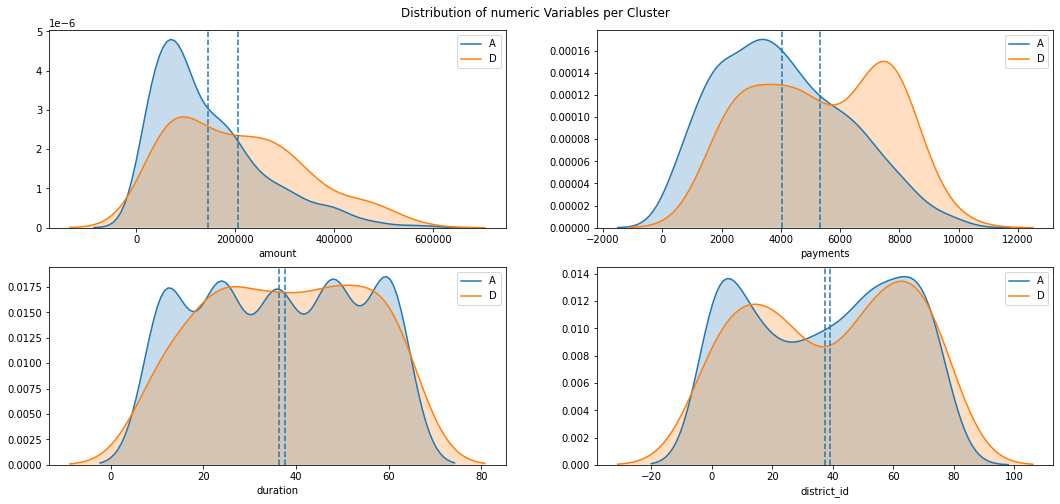

In [61]:
columns = ['amount','payments','duration','district_id']

fig, axs = plt.subplots(2,2, figsize=(18,8))

for column, ax in zip(columns, axs.flatten()):
     for each in ['A','D']:
        sns.kdeplot(loan_account[column][loan['status2']==each],ax=ax,label=each,shade=True)
        ax.axvline(loan_account[column][loan['status2']==each].mean(),ls='--')
        ax.set_xlabel(column)

plt.suptitle('Distribution of numeric Variables per Cluster', y=0.92)
plt.show()

NameError: name 'loan_order' is not defined

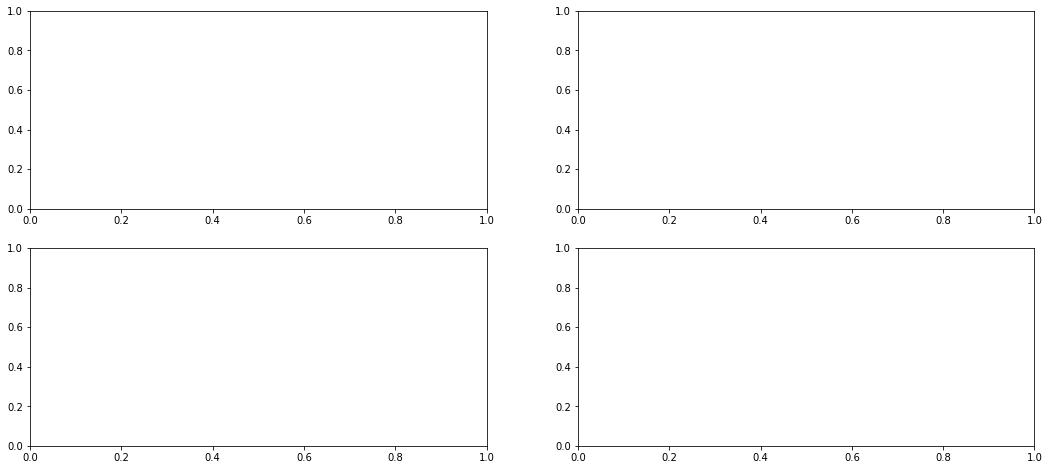

In [62]:
columns = ['amount_loan','payments','duration','amount_order']

fig, axs = plt.subplots(2,2, figsize=(18,8))

for column, ax in zip(columns, axs.flatten()):
     for each in ['A','D']:
        sns.kdeplot(loan_order[column][loan_order['status2']==each],ax=ax,label=each,shade=True)
        ax.axvline(loan_order[column][loan_order['status2']==each].mean(),ls='--')
        ax.set_xlabel(column)

plt.suptitle('Distribution of numeric Variables per Cluster', y=0.92)
plt.show()

In [ ]:
loan_order_trans.columns

In [ ]:
columns = ['amount_loan','payments','duration','amount_order','amount','balance']

fig, axs = plt.subplots(2,3, figsize=(18,8))

for column, ax in zip(columns, axs.flatten()):
     for each in ['A','D']:
        sns.kdeplot(loan_order_trans[column][loan_order_trans['status2']==each],ax=ax,label=each,shade=True)
        ax.axvline(loan_order_trans[column][loan_order_trans['status2']==each].mean(),ls='--')
        ax.set_xlabel(column)

plt.suptitle('Distribution of numeric Variables per Cluster', y=0.92)
plt.show()